In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import cv2
import torch.nn as nn
import pandas as pd
import torchvision
import albumentations as A
import pickle
from PIL import Image
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision.models.segmentation import FCN_ResNet50_Weights
from torchinfo import summary

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.set_printoptions(threshold=np.inf)

In [44]:
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(f"GPU Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"GPU Allocated Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"GPU Reserved Memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    print("CUDA Version:", torch.version.cuda)
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
GPU Total Memory: 6.44 GB
GPU Allocated Memory: 0.89 GB
GPU Reserved Memory: 2.51 GB
CUDA Version: 12.6


Image shape: (530, 730, 3)


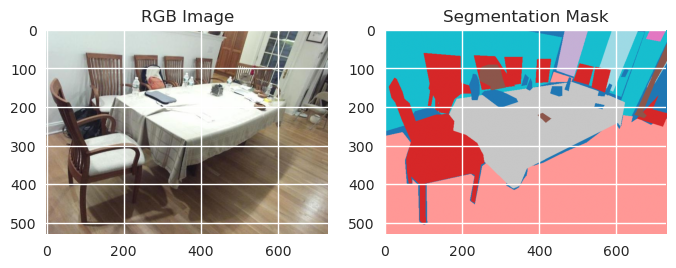

In [45]:
root_dir = "data/SUN_RGBD/"

def print_pair_image_label(image, label) -> None:
    print("Image shape:", np.array(image).shape)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("RGB Image")

    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap="tab20")
    plt.title("Segmentation Mask")

    plt.show()

print_pair_image_label(Image.open(root_dir + "image/train/img-000001.jpg"), Image.open(root_dir + "label13/train/img13labels-000001.png"))

In [46]:
class SunRGBDDataset(Dataset):
    def __init__(self, path_file, root_dir="", transform=None):
        self.transform = transform
        self.path_df = pd.read_csv(path_file, sep=' ', header=None)
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.path_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.path_df.iloc[idx, 0])
        mask_path = os.path.join(self.root_dir, self.path_df.iloc[idx, 2])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            transformed = self.transform(image=np.array(image), mask=np.array(mask))
            image = transformed['image']
            mask = transformed['mask']
            mask = mask.long()

        return image, mask

train_transform = A.Compose([
    A.Resize(height=256, width=352, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GridDistortion(p=0.4),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(p=0.4),
    A.GaussNoise(p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

test_transform = A.Compose([
    A.Resize(height=256, width=352, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

/home/marcotuliopin/miniconda3/envs/poc/lib/python3.13/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [47]:
train_dataset = SunRGBDDataset(
    path_file=root_dir + "train13.txt",
    root_dir=root_dir,
    transform=train_transform,
)

val_dataset = SunRGBDDataset(
    path_file=root_dir + "split/val13.txt",
    root_dir=root_dir,
    transform=test_transform,
)

test_dataset = SunRGBDDataset(
    path_file=root_dir + "split/test13.txt",
    root_dir=root_dir,
    transform=test_transform,
)

In [48]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [49]:
num_classes = 14
# model = torchvision.models.segmentation.fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
model = torchvision.models.segmentation.fcn_resnet50()
model.classifier[4] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
)
# model.aux_classifier[4] = nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
# )
summary(model, input_size=(4, 3, 256, 352), device=device.type)

Layer (type:depth-idx)                        Output Shape              Param #
FCN                                           [4, 14, 256, 352]         --
├─IntermediateLayerGetter: 1-1                [4, 2048, 32, 44]         --
│    └─Conv2d: 2-1                            [4, 64, 128, 176]         9,408
│    └─BatchNorm2d: 2-2                       [4, 64, 128, 176]         128
│    └─ReLU: 2-3                              [4, 64, 128, 176]         --
│    └─MaxPool2d: 2-4                         [4, 64, 64, 88]           --
│    └─Sequential: 2-5                        [4, 256, 64, 88]          --
│    │    └─Bottleneck: 3-1                   [4, 256, 64, 88]          75,008
│    │    └─Bottleneck: 3-2                   [4, 256, 64, 88]          70,400
│    │    └─Bottleneck: 3-3                   [4, 256, 64, 88]          70,400
│    └─Sequential: 2-6                        [4, 512, 32, 44]          --
│    │    └─Bottleneck: 3-4                   [4, 512, 32, 44]          379,392

In [50]:
class CheckpointSaver:
    def __init__(self, model, optimizer, save_dir):
        self.model = model
        self.optimizer = optimizer
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def save(self, epoch, verbose=False):
        checkpoint_path = os.path.join(self.save_dir, f"checkpoint_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, checkpoint_path)
        if verbose:
            print(f"Checkpoint saved at {checkpoint_path}")

    def load(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from {checkpoint_path}, starting from epoch {start_epoch}")
        return start_epoch

In [51]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, checkpoint_saver=None):
        self.counter = 0
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.checkpoint_saver = checkpoint_saver

    def __call__(self, val_loss, epoch):
        if val_loss < self.best_loss - self.min_delta:
            self.checkpoint_saver.save(epoch)
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                return True
        return False

In [52]:
class SegmentationTrainer:
    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

    def train_epoch(self, data_loader, epoch):
        self.model.train()
        running_loss = 0.0
        
        for images, masks in tqdm(data_loader, desc=f"Training Epoch {epoch}"):
            images = images.to(self.device)
            masks = masks.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)['out']
            loss = self.criterion(outputs, masks)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            
        return running_loss / len(data_loader)

    def validate(self, data_loader, epoch):
        self.model.eval()
        running_loss = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(data_loader, desc=f"Validation Epoch {epoch}"):
                images = images.to(self.device)
                masks = masks.to(self.device)

                outputs = self.model(images)['out']
                loss = self.criterion(outputs, masks)

                running_loss += loss.item()
                
        return running_loss / len(data_loader)


In [53]:
lr = 1e-4
weight_decay = 1e-3
num_epochs = 100
min_delta = 5e-4
patience = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode="min", factor=0.1, patience=5
)
checkpoint_saver = CheckpointSaver(model, optimizer, save_dir="checkpoints/no_pretrain")
early_stopping = EarlyStopping(
    patience=patience, min_delta=min_delta, checkpoint_saver=checkpoint_saver
)
trainer = SegmentationTrainer(model, optimizer, criterion, device)
train_losses = []
val_losses = []

In [54]:
for epoch in range(num_epochs):
    train_loss = trainer.train_epoch(train_loader, epoch)
    val_loss = trainer.validate(val_loader, epoch)

    train_losses.append(train_loss)
    pickle.dump(train_losses, open("train_losses.pkl", "wb"))
    val_losses.append(val_loss)
    pickle.dump(val_losses, open("val_losses.pkl", "wb"))

    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    
    if early_stopping(val_loss, epoch):
        break


Validation Epoch 0: 100%|██████████| 119/119 [00:08<00:00, 13.55it/s]


Epoch 1:
  Train Loss: 1.5252
  Val Loss: 1.1730


Validation Epoch 1: 100%|██████████| 119/119 [00:08<00:00, 13.33it/s]


Epoch 2:
  Train Loss: 1.3282
  Val Loss: 1.1330


Validation Epoch 2: 100%|██████████| 119/119 [00:08<00:00, 13.50it/s]


Epoch 3:
  Train Loss: 1.2603
  Val Loss: 1.0552


Validation Epoch 3: 100%|██████████| 119/119 [00:09<00:00, 13.08it/s]


Epoch 4:
  Train Loss: 1.2062
  Val Loss: 1.0406


Validation Epoch 4: 100%|██████████| 119/119 [00:09<00:00, 13.19it/s]


Epoch 5:
  Train Loss: 1.1661
  Val Loss: 1.0604


Validation Epoch 5: 100%|██████████| 119/119 [00:08<00:00, 13.44it/s]


Epoch 6:
  Train Loss: 1.1372
  Val Loss: 1.0353


Validation Epoch 6: 100%|██████████| 119/119 [00:08<00:00, 13.59it/s]


Epoch 7:
  Train Loss: 1.1088
  Val Loss: 1.0042


Validation Epoch 7: 100%|██████████| 119/119 [00:08<00:00, 13.70it/s]


Epoch 8:
  Train Loss: 1.0811
  Val Loss: 1.0082


Validation Epoch 8: 100%|██████████| 119/119 [00:08<00:00, 13.73it/s]


Epoch 9:
  Train Loss: 1.0678
  Val Loss: 1.0048


Validation Epoch 9: 100%|██████████| 119/119 [00:08<00:00, 13.92it/s]


Epoch 10:
  Train Loss: 1.0480
  Val Loss: 0.9954


Validation Epoch 10: 100%|██████████| 119/119 [00:08<00:00, 13.72it/s]


Epoch 11:
  Train Loss: 1.0353
  Val Loss: 0.9790


Validation Epoch 11: 100%|██████████| 119/119 [00:08<00:00, 13.64it/s]


Epoch 12:
  Train Loss: 1.0137
  Val Loss: 1.0048


Validation Epoch 12: 100%|██████████| 119/119 [00:08<00:00, 13.81it/s]


Epoch 13:
  Train Loss: 1.0044
  Val Loss: 0.9898


Validation Epoch 13: 100%|██████████| 119/119 [00:08<00:00, 13.51it/s]


Epoch 14:
  Train Loss: 0.9878
  Val Loss: 0.9694


Validation Epoch 14: 100%|██████████| 119/119 [00:08<00:00, 13.67it/s]


Epoch 15:
  Train Loss: 0.9762
  Val Loss: 0.9812


Validation Epoch 15: 100%|██████████| 119/119 [00:08<00:00, 13.81it/s]


Epoch 16:
  Train Loss: 0.9666
  Val Loss: 1.0006


Validation Epoch 16: 100%|██████████| 119/119 [00:08<00:00, 13.54it/s]


Epoch 17:
  Train Loss: 0.9475
  Val Loss: 0.9845


Validation Epoch 17: 100%|██████████| 119/119 [00:08<00:00, 13.66it/s]


Epoch 18:
  Train Loss: 0.9420
  Val Loss: 0.9616


Validation Epoch 18: 100%|██████████| 119/119 [00:08<00:00, 13.64it/s]


Epoch 19:
  Train Loss: 0.9317
  Val Loss: 0.9831


Validation Epoch 19: 100%|██████████| 119/119 [00:08<00:00, 13.67it/s]


Epoch 20:
  Train Loss: 0.9162
  Val Loss: 1.0040


Validation Epoch 20: 100%|██████████| 119/119 [00:08<00:00, 13.60it/s]


Epoch 21:
  Train Loss: 0.9020
  Val Loss: 0.9800


Validation Epoch 21: 100%|██████████| 119/119 [00:08<00:00, 13.60it/s]


Epoch 22:
  Train Loss: 0.8991
  Val Loss: 0.9618


Validation Epoch 22: 100%|██████████| 119/119 [00:08<00:00, 13.89it/s]


Epoch 23:
  Train Loss: 0.8917
  Val Loss: 0.9632


Validation Epoch 23: 100%|██████████| 119/119 [00:08<00:00, 13.54it/s]


Epoch 24:
  Train Loss: 0.8775
  Val Loss: 0.9971


Validation Epoch 24: 100%|██████████| 119/119 [00:08<00:00, 13.70it/s]


Epoch 25:
  Train Loss: 0.8068
  Val Loss: 0.9380


Validation Epoch 25: 100%|██████████| 119/119 [00:08<00:00, 14.01it/s]


Epoch 26:
  Train Loss: 0.7802
  Val Loss: 0.9400


Validation Epoch 26: 100%|██████████| 119/119 [00:08<00:00, 13.51it/s]


Epoch 27:
  Train Loss: 0.7683
  Val Loss: 0.9384


Validation Epoch 27: 100%|██████████| 119/119 [00:08<00:00, 13.47it/s]


Epoch 28:
  Train Loss: 0.7595
  Val Loss: 0.9382


Validation Epoch 28: 100%|██████████| 119/119 [00:08<00:00, 13.71it/s]


Epoch 29:
  Train Loss: 0.7510
  Val Loss: 0.9490


Validation Epoch 29: 100%|██████████| 119/119 [00:08<00:00, 13.60it/s]


Epoch 30:
  Train Loss: 0.7436
  Val Loss: 0.9478


Validation Epoch 30: 100%|██████████| 119/119 [00:08<00:00, 13.65it/s]


Epoch 31:
  Train Loss: 0.7400
  Val Loss: 0.9444


Validation Epoch 31: 100%|██████████| 119/119 [00:08<00:00, 13.70it/s]


Epoch 32:
  Train Loss: 0.7305
  Val Loss: 0.9508


Validation Epoch 32: 100%|██████████| 119/119 [00:08<00:00, 13.81it/s]


Epoch 33:
  Train Loss: 0.7223
  Val Loss: 0.9478


Validation Epoch 33: 100%|██████████| 119/119 [00:08<00:00, 13.54it/s]


Epoch 34:
  Train Loss: 0.7301
  Val Loss: 0.9491


Validation Epoch 34: 100%|██████████| 119/119 [00:08<00:00, 13.58it/s]

Epoch 35:
  Train Loss: 0.7253
  Val Loss: 0.9480
Early stopping triggered


In [55]:
def plot_loss_curves(train_losses, val_losses, save_path=None):
    """
    Plota curvas de loss de treino e validação com formatação profissional.
    
    Args:
        train_losses (list): Lista de valores de loss de treino por época.
        val_losses (list): Lista de valores de loss de validação por época.
        save_path (str, optional): Caminho para salvar a figura. Se None, mostra o plot.
    """
    plt.figure(figsize=(10, 6))
    
    # Definindo estilo
    plt.style.use('seaborn-v0_8')
    epochs = np.arange(1, len(train_losses) + 1)
    
    # Plotando as curvas
    train_line, = plt.plot(epochs, train_losses, 
                          color='#1f77b4',  # Azul
                          linewidth=2.5, 
                          marker='o',
                          markersize=8,
                          label='Train Loss')
    
    val_line, = plt.plot(epochs, val_losses, 
                        color='#ff7f0e',  # Laranja
                        linewidth=2.5, 
                        marker='s',
                        markersize=8,
                        label='Validation Loss')
    
    # Ajustes estéticos
    plt.title('Training and Validation Loss', fontsize=14, pad=20)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(epochs)
    
    # Adicionando anotação com métricas finais
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    plt.annotate(f'Final Train Loss: {final_train_loss:.4f}\nFinal Val Loss: {final_val_loss:.4f}',
                xy=(0.98, 0.98),
                xycoords='axes fraction',
                ha='right',
                va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.legend(fontsize=12, framealpha=1)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot salvo em: {save_path}")
    else:
        plt.show()

Plot salvo em: loss_curves.png


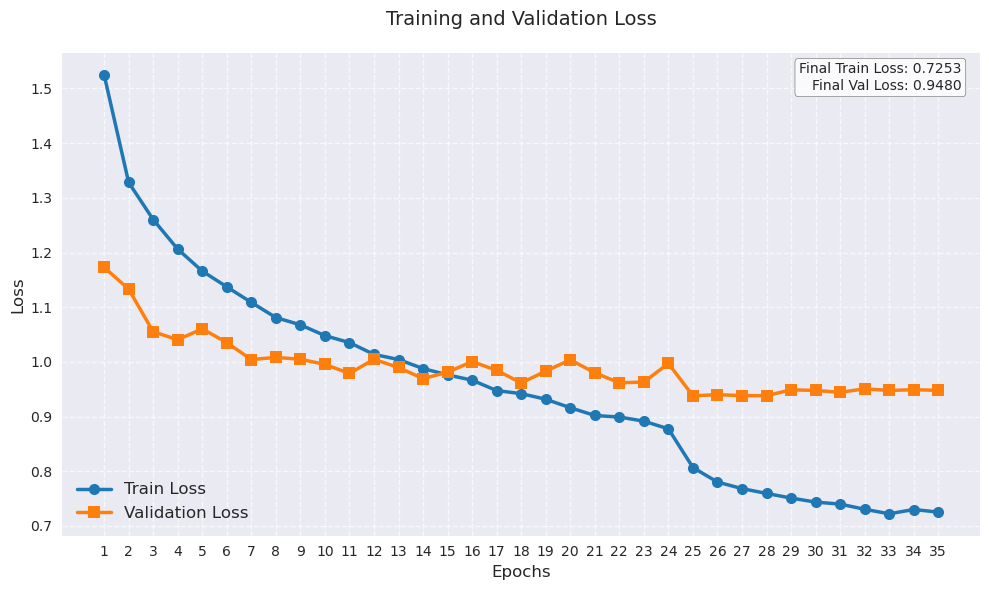

In [56]:
plot_loss_curves(train_losses, val_losses, save_path="loss_curves.png")

In [57]:
def test_model(model, data_loader, device, num_classes=14):
    model.eval()
    confusion_matrix = np.zeros((num_classes, num_classes))
    
    # Métricas
    total_iou = 0.0
    total_dice = 0.0
    total_pixel_acc = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Testando modelo"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Predição
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)
            
            # Converter para CPU e numpy para cálculo de métricas
            preds_np = preds.cpu().numpy()
            masks_np = masks.cpu().numpy()
            
            # Atualizar matriz de confusão
            for i in range(preds_np.shape[0]):
                pred_flat = preds_np[i].flatten()
                mask_flat = masks_np[i].flatten()
                
                # Atualizar matriz de confusão
                for t, p in zip(mask_flat, pred_flat):
                    confusion_matrix[t, p] += 1
                    
                # Calcular IoU para cada imagem
                intersection = np.logical_and(preds_np[i], masks_np[i])
                union = np.logical_or(preds_np[i], masks_np[i])
                iou = np.sum(intersection) / (np.sum(union) + 1e-7)
                
                # Calcular Dice coefficient
                dice = (2.0 * np.sum(intersection)) / (np.sum(preds_np[i]) + np.sum(masks_np[i]) + 1e-7)
                
                # Acurácia de pixel
                pixel_acc = np.mean(preds_np[i] == masks_np[i])
                
                total_iou += iou
                total_dice += dice
                total_pixel_acc += pixel_acc
                total_samples += 1
                
    # Calcular métricas por classe
    class_iou = np.diag(confusion_matrix) / (np.sum(confusion_matrix, axis=1) + 
                                              np.sum(confusion_matrix, axis=0) - 
                                              np.diag(confusion_matrix) + 1e-7)
    
    # Métricas médias
    mean_iou = np.mean(class_iou)
    mean_pixel_acc = total_pixel_acc / total_samples
    mean_dice = total_dice / total_samples
    
    # Exibir resultados
    print(f"Métricas de teste:")
    print(f"  Mean IoU: {mean_iou:.4f}")
    print(f"  Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"  Pixel Accuracy: {mean_pixel_acc:.4f}")
    
    # IoU por classe
    print("\nIoU por classe:")
    for i in range(num_classes):
        print(f"  Classe {i}: {class_iou[i]:.4f}")
    
    # Criar visualizações
    plot_confusion_matrix(confusion_matrix, title='Confusion Matrix')
    visualize_predictions(model, data_loader, device, num_samples=5)
    
    return {
        'mean_iou': mean_iou,
        'mean_dice': mean_dice,
        'pixel_acc': mean_pixel_acc,
        'class_iou': class_iou,
        'confusion_matrix': confusion_matrix
    }

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, normalize=True):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)
        
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_predictions(model, data_loader, device, num_samples=5):
    model.eval()
    images, masks = next(iter(data_loader))
    images = images[:num_samples].to(device)
    masks = masks[:num_samples].cpu().numpy()
    
    with torch.no_grad():
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    
    # Denormalizar imagens
    images = images.cpu().numpy()
    images = np.transpose(images, (0, 2, 3, 1))
    # Reversão da normalização para visualização
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    
    plt.figure(figsize=(15, 4*num_samples))
    for i in range(num_samples):
        # Imagem original
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(images[i])
        plt.title("Imagem Original")
        plt.axis('off')
        
        # Máscara real
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(masks[i], cmap='tab20')
        plt.title("Máscara Real")
        plt.axis('off')
        
        # Predição
        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(preds[i], cmap='tab20')
        plt.title("Predição")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('predicoes.png', dpi=300, bbox_inches='tight')
    plt.show()

Testando modelo: 100%|██████████| 1144/1144 [02:55<00:00,  6.53it/s]


Métricas de teste:
  Mean IoU: 0.4126
  Mean Dice Coefficient: 0.1021
  Pixel Accuracy: 0.6701

IoU por classe:
  Classe 0: 0.3598
  Classe 1: 0.3820
  Classe 2: 0.2311
  Classe 3: 0.4582
  Classe 4: 0.5392
  Classe 5: 0.7483
  Classe 6: 0.3147
  Classe 7: 0.2637
  Classe 8: 0.3436
  Classe 9: 0.4072
  Classe 10: 0.4795
  Classe 11: 0.1244
  Classe 12: 0.6592
  Classe 13: 0.4659


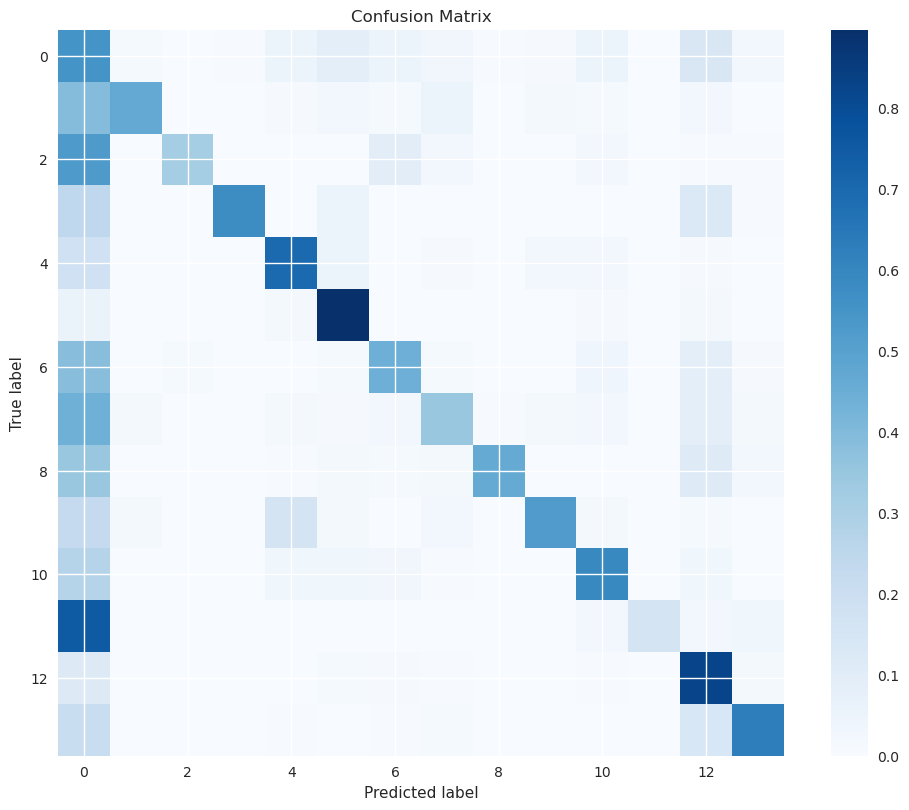

IndexError: index 4 is out of bounds for axis 0 with size 4

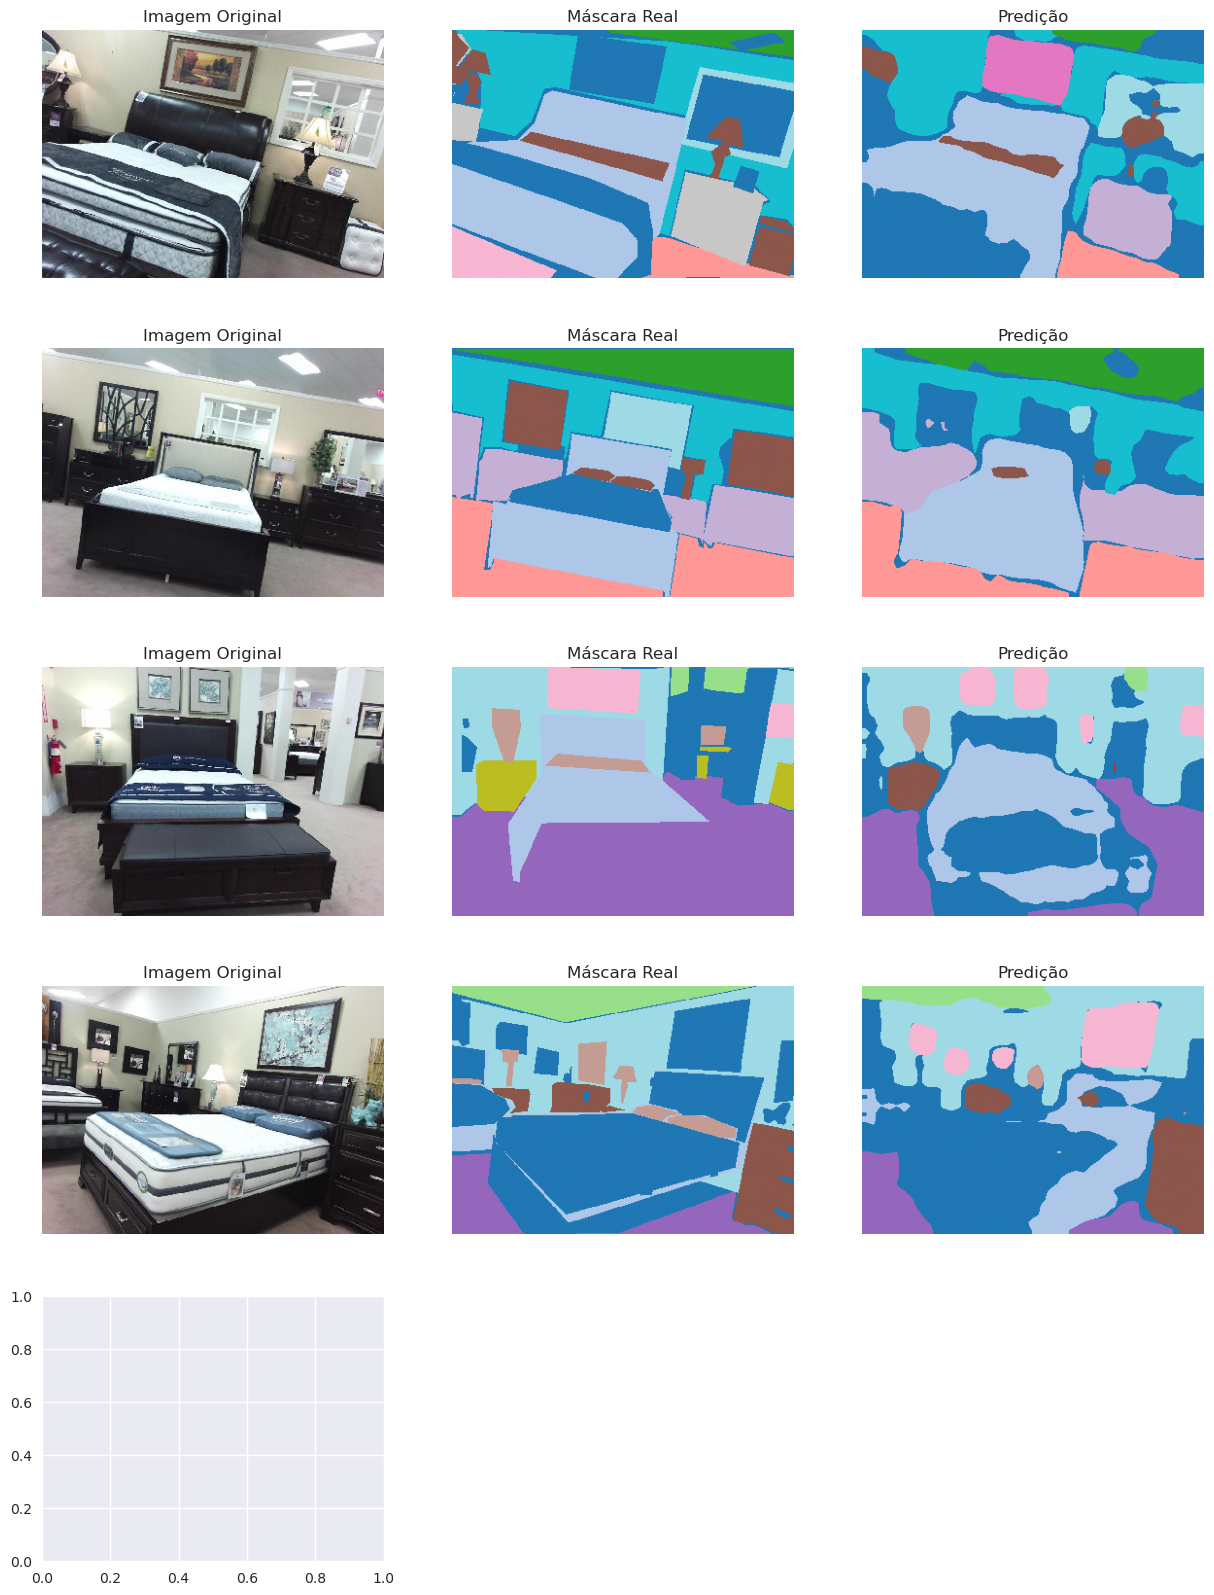

In [58]:
model = model.to(device)

results = test_model(model, test_loader, device, num_classes)

# Salvar resultados
with open('test_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print(f"Resultados finais do teste:")
print(f"IoU médio: {results['mean_iou']:.4f}")
print(f"Dice médio: {results['mean_dice']:.4f}")
print(f"Acurácia de pixel: {results['pixel_acc']:.4f}")